In [1]:
import torch
import xarray as xr
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import time
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import LambdaLR

In [2]:
dataset_path = 'gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-240x121_equiangular_with_poles_conservative.zarr'
ds = xr.open_zarr(dataset_path, consolidated=True)
print(ds)

<xarray.Dataset> Size: 2TB
Dimensions:                                           (time: 93544,
                                                       longitude: 240,
                                                       latitude: 121, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 968B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 2kB ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 11GB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 11GB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float3

In [3]:
print("Dimensiones del dataset:", ds.dims)

Dimensiones del dataset: FrozenMappingWarningOnValuesAccess({'time': 93544, 'longitude': 240, 'latitude': 121, 'level': 13})


In [4]:
subset = ds.isel(latitude=slice(0, 100), longitude=slice(0, 100), time=slice(0, 10))  # Ajusta la región espacial
print(subset)

<xarray.Dataset> Size: 92MB
Dimensions:                                           (time: 10,
                                                       longitude: 100,
                                                       latitude: 100, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 800B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 800B ...
  * time                                              (time) datetime64[ns] 80B ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 400kB ...
    10m_v_component_of_wind                           (time, longitude, latitude) float32 400kB ...
    10m_wind_speed                                    (time, longitude, latitude) float32 400kB ...
    2m_dewpoint_temperature                           (time, longitude, latitude) float3

In [5]:
for var in subset.data_vars:
    print(f"{var}: {subset[var].shape}")

10m_u_component_of_wind: (10, 100, 100)
10m_v_component_of_wind: (10, 100, 100)
10m_wind_speed: (10, 100, 100)
2m_dewpoint_temperature: (10, 100, 100)
2m_temperature: (10, 100, 100)
above_ground: (10, 13, 100, 100)
ageostrophic_wind_speed: (10, 13, 100, 100)
angle_of_sub_gridscale_orography: (100, 100)
anisotropy_of_sub_gridscale_orography: (100, 100)
boundary_layer_height: (10, 100, 100)
divergence: (10, 13, 100, 100)
eddy_kinetic_energy: (10, 100, 100)
geopotential: (10, 13, 100, 100)
geopotential_at_surface: (100, 100)
geostrophic_wind_speed: (10, 13, 100, 100)
high_vegetation_cover: (100, 100)
integrated_vapor_transport: (10, 100, 100)
lake_cover: (100, 100)
land_sea_mask: (100, 100)
lapse_rate: (10, 13, 100, 100)
leaf_area_index_high_vegetation: (10, 100, 100)
leaf_area_index_low_vegetation: (10, 100, 100)
low_vegetation_cover: (100, 100)
mean_sea_level_pressure: (10, 100, 100)
mean_surface_latent_heat_flux: (10, 100, 100)
mean_surface_net_long_wave_radiation_flux: (10, 100, 100)


In [6]:
variables = ['u_component_of_wind', 'v_component_of_wind', 
             'temperature', 'specific_humidity', 'mean_sea_level_pressure']

subset_selected = subset[variables]
print(subset_selected)

<xarray.Dataset> Size: 21MB
Dimensions:                  (time: 10, level: 13, longitude: 100, latitude: 100)
Coordinates:
  * latitude                 (latitude) float64 800B -90.0 -88.5 ... 57.0 58.5
  * level                    (level) int64 104B 50 100 150 200 ... 850 925 1000
  * longitude                (longitude) float64 800B 0.0 1.5 ... 147.0 148.5
  * time                     (time) datetime64[ns] 80B 1959-01-01 ... 1959-01...
Data variables:
    u_component_of_wind      (time, level, longitude, latitude) float32 5MB ...
    v_component_of_wind      (time, level, longitude, latitude) float32 5MB ...
    temperature              (time, level, longitude, latitude) float32 5MB ...
    specific_humidity        (time, level, longitude, latitude) float32 5MB ...
    mean_sea_level_pressure  (time, longitude, latitude) float32 400kB ...


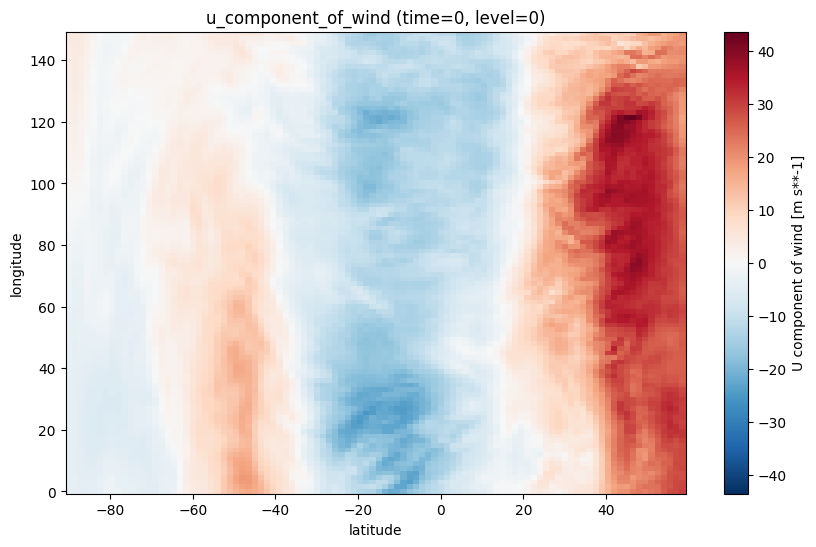

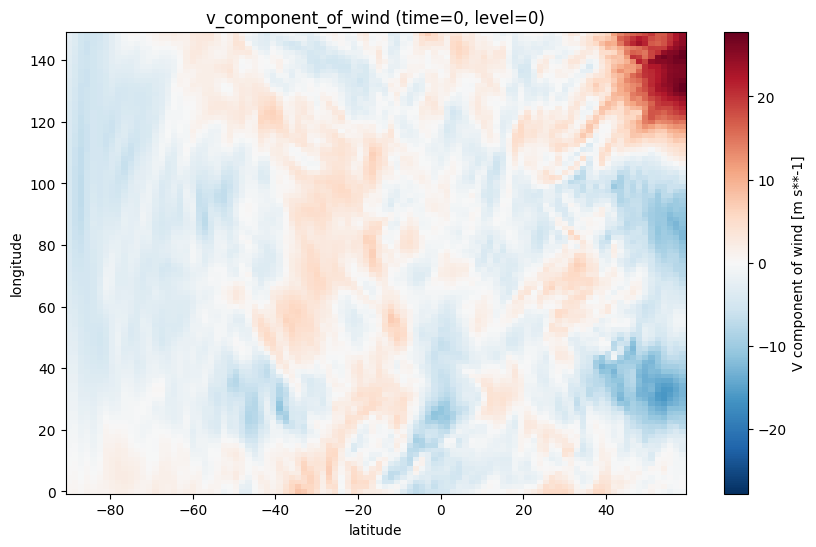

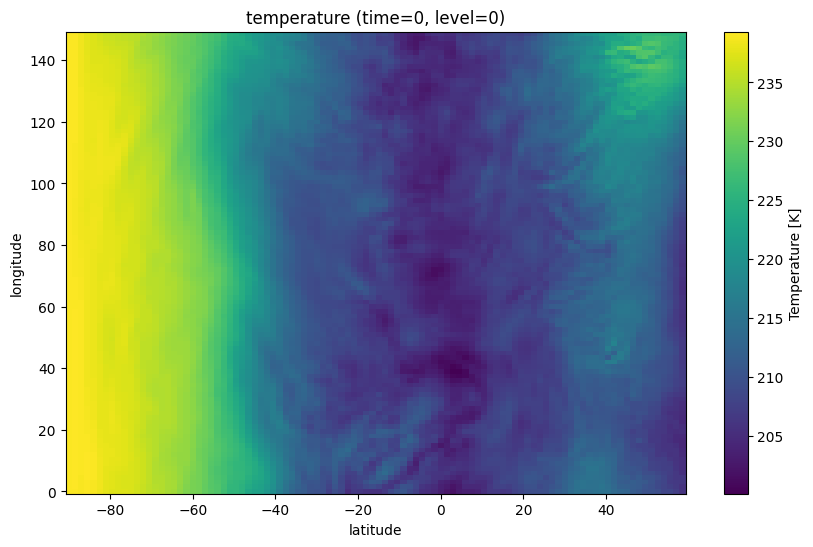

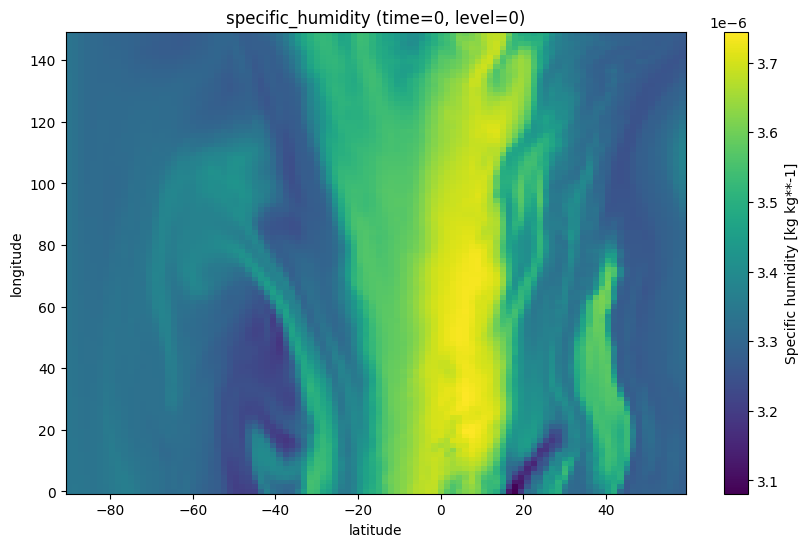

In [7]:
time_idx = 0  # Índice de tiempo
level_idx = 0  # Índice de nivel (si aplica)

for var in ['u_component_of_wind', 'v_component_of_wind', 
             'temperature', 'specific_humidity']:
    data = subset_selected[var].isel(time=time_idx, level=level_idx)
    plt.figure(figsize=(10, 6))
    data.plot()
    plt.title(f"{var} (time={time_idx}, level={level_idx})")
    plt.show()

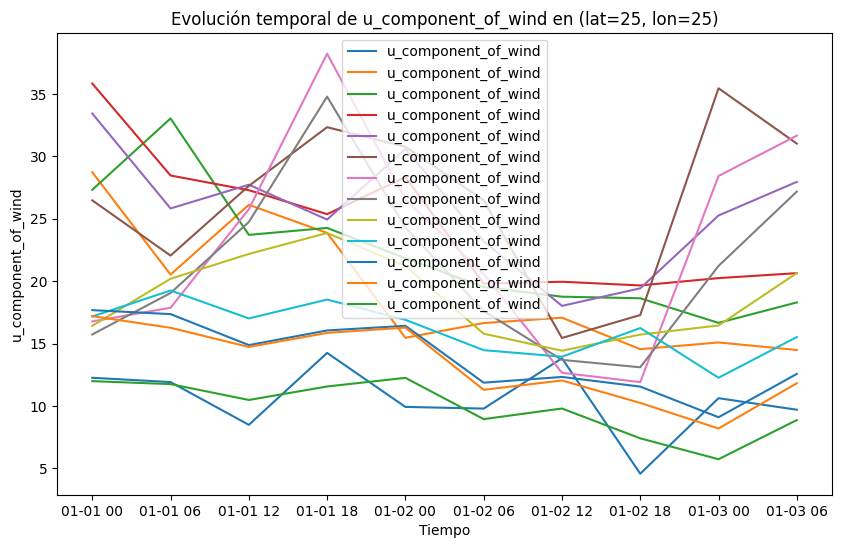

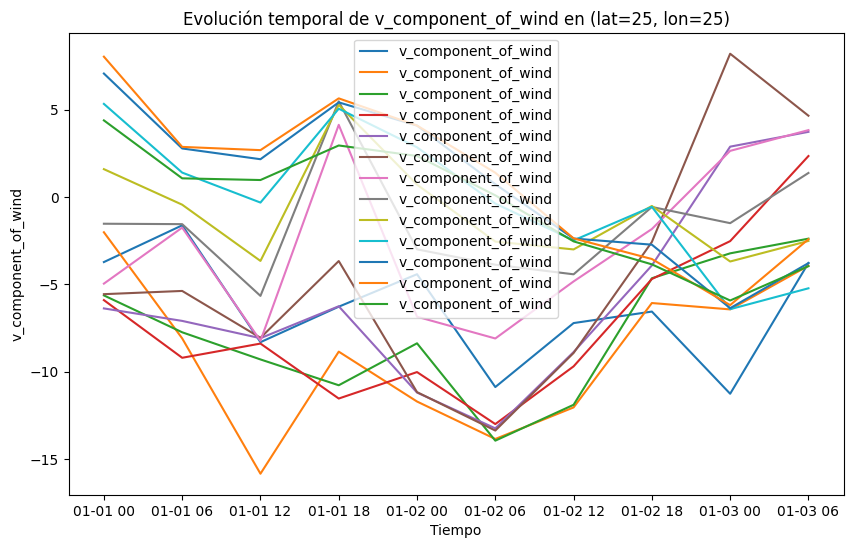

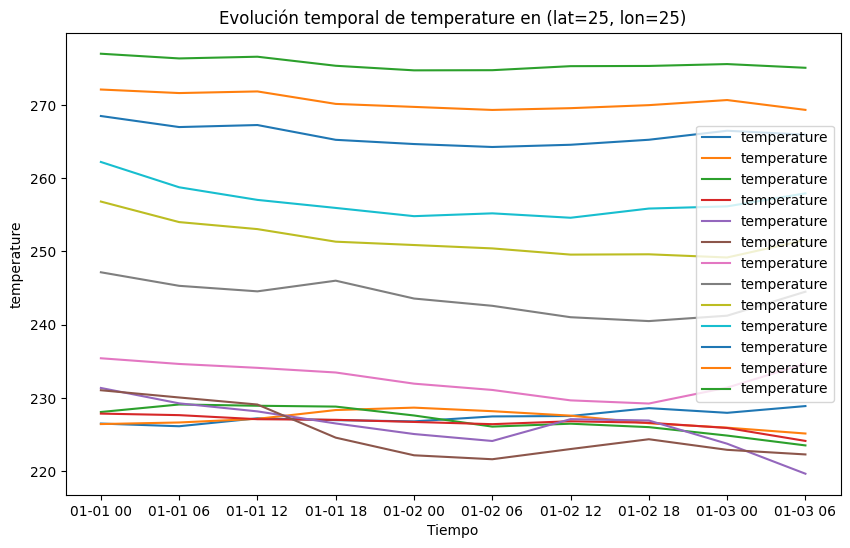

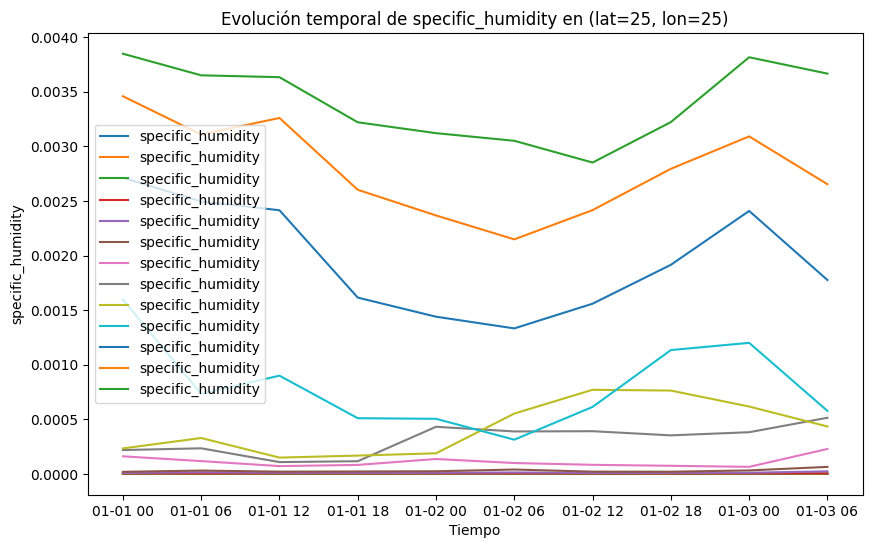

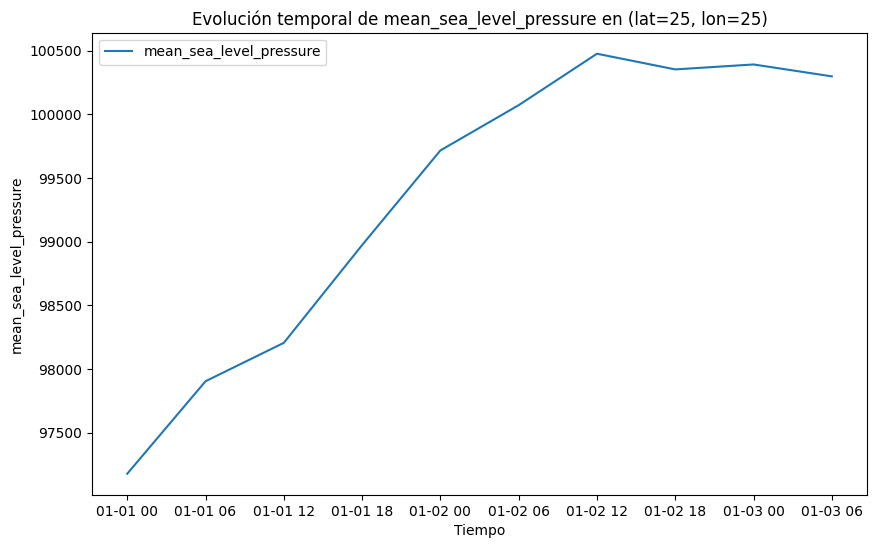

In [8]:
latitude_idx = 25  # Índice de latitud
longitude_idx = 25  # Índice de longitud

for var in variables:
    time_series = subset_selected[var].isel(latitude=latitude_idx, longitude=longitude_idx).values
    plt.figure(figsize=(10, 6))
    plt.plot(subset_selected['time'].values, time_series, label=var)
    plt.title(f"Evolución temporal de {var} en (lat={latitude_idx}, lon={longitude_idx})")
    plt.xlabel("Tiempo")
    plt.ylabel(var)
    plt.legend()
    plt.show()

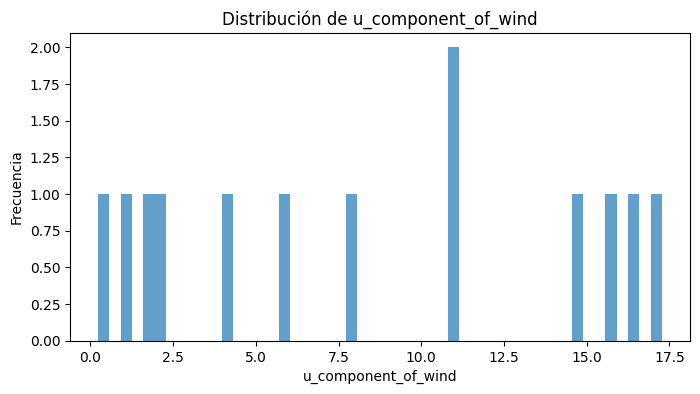

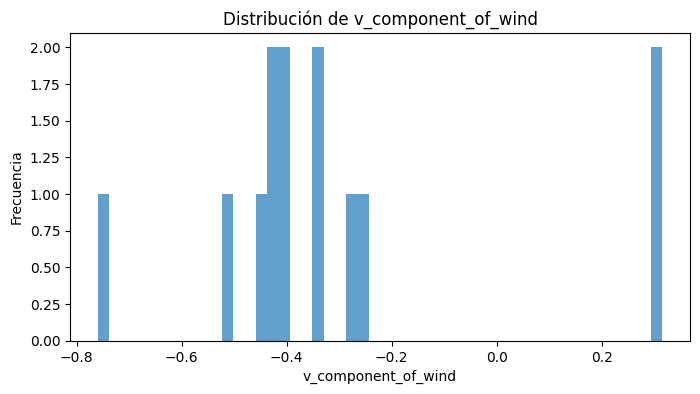

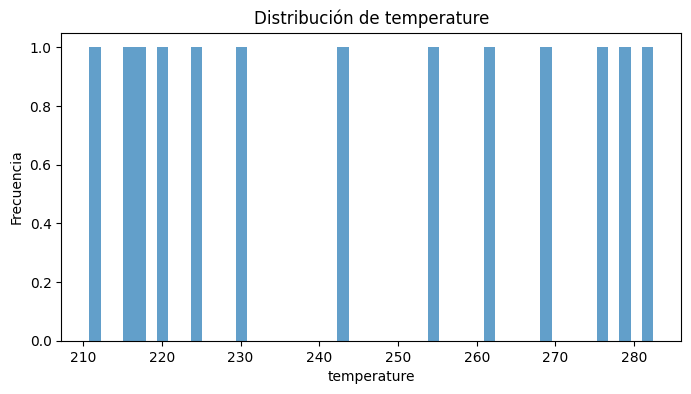

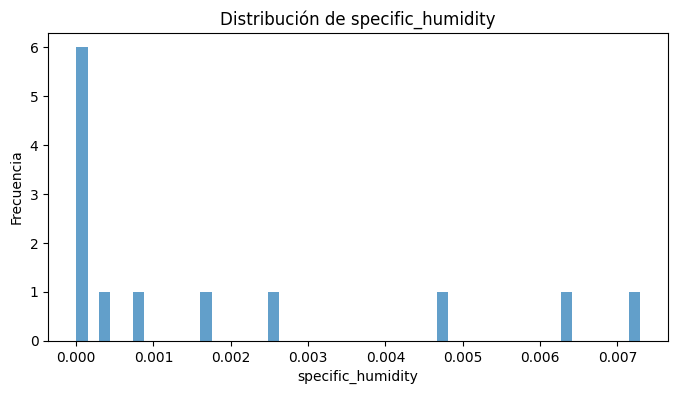

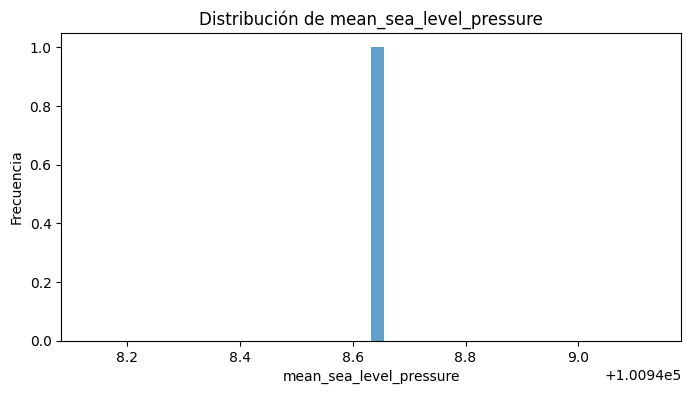

In [81]:
for var in variables:
    data = subset_selected[var].isel(time=0).mean(dim=('latitude', 'longitude')).compute()
    plt.figure(figsize=(8, 4))
    plt.hist(data.values.flatten(), bins=50, alpha=0.7)
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.show()

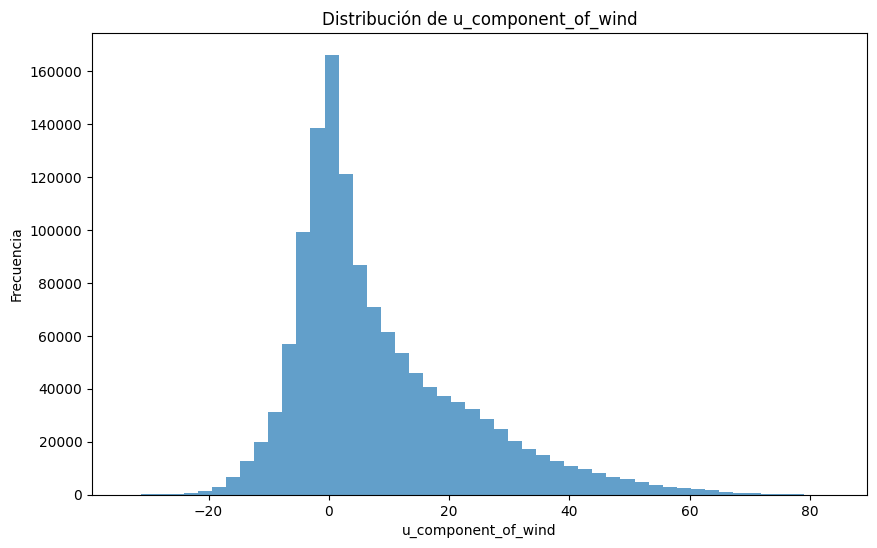

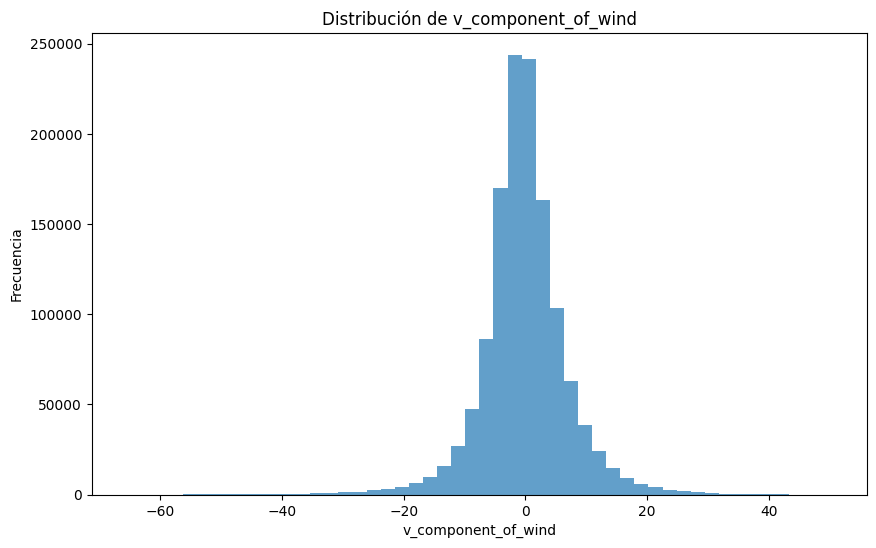

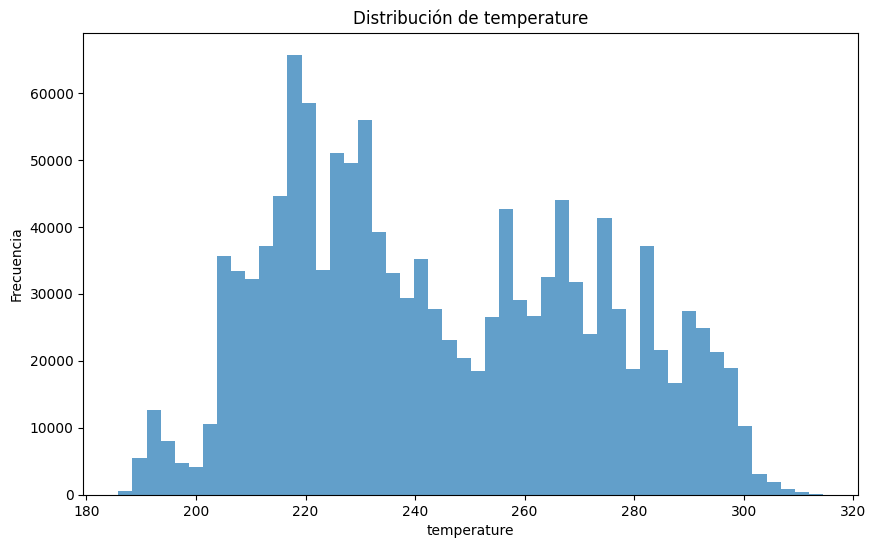

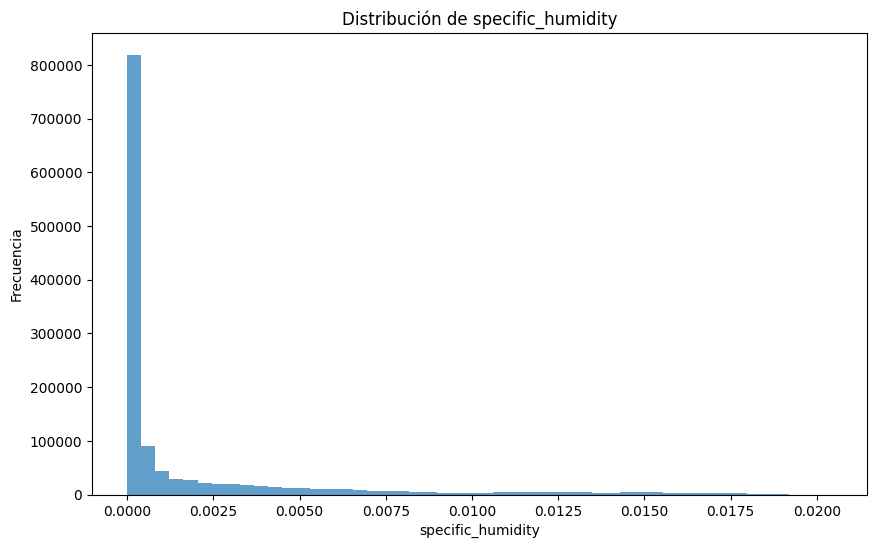

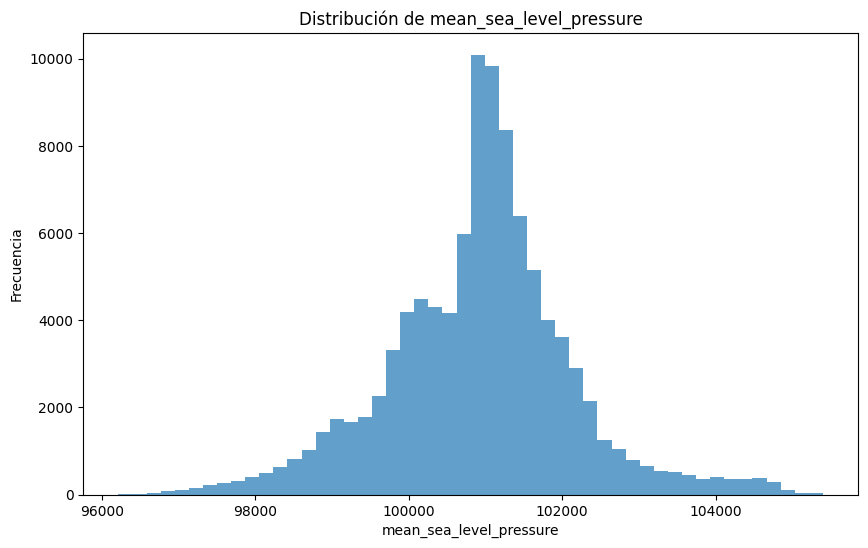

In [9]:
for var in variables:
    data = subset_selected[var].values.flatten()  # Aplanar los datos para el histograma
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=50, alpha=0.7)
    plt.title(f"Distribución de {var}")
    plt.xlabel(var)
    plt.ylabel("Frecuencia")
    plt.show()

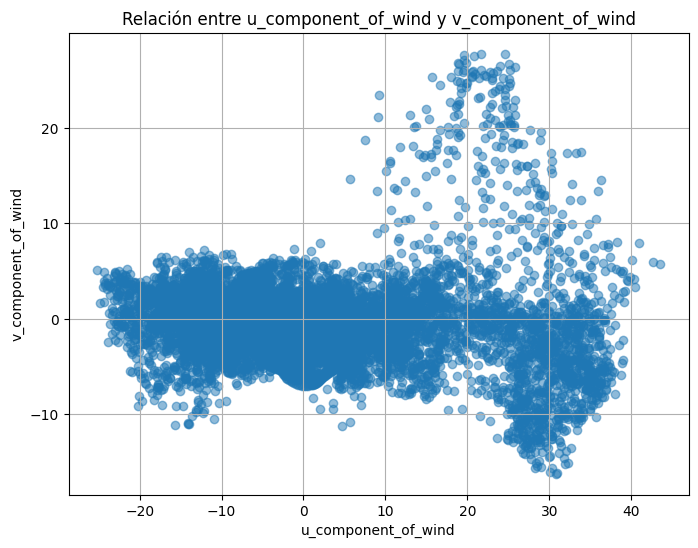

In [10]:
time_idx = 0
level_idx = 0

x_var = 'u_component_of_wind'
y_var = 'v_component_of_wind'

x_data = subset_selected[x_var].isel(time=time_idx, level=level_idx).values.flatten()
y_data = subset_selected[y_var].isel(time=time_idx, level=level_idx).values.flatten()

plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, alpha=0.5)
plt.title(f"Relación entre {x_var} y {y_var}")
plt.xlabel(x_var)
plt.ylabel(y_var)
plt.grid()
plt.show()

In [11]:
print(f"Subset dimensions: {subset.dims}")
print(f"Timestamps in subset: {subset.sizes['time']}")
print(f"Latitude size: {subset.sizes['latitude']}, Longitude size: {subset.sizes['longitude']}")


Subset dimensions: FrozenMappingWarningOnValuesAccess({'time': 10, 'longitude': 100, 'latitude': 100, 'level': 13})
Timestamps in subset: 10
Latitude size: 100, Longitude size: 100


In [12]:
height, width = subset_selected.sizes['latitude'], subset_selected.sizes['longitude']
print(f"Height: {height}, Width: {width}")


Height: 100, Width: 100


In [13]:
levels = subset_selected.sizes['level']
print(f"Levels: {levels}")


Levels: 13


In [14]:
times = subset_selected.sizes['time']
print(f"Timestamps: {times}")


Timestamps: 10


In [15]:
train_idx = 7  # 7 timestamps para entrenamiento (70%)
val_idx = 9    # 2 timestamps para validación (20%)
test_idx = 10  # 1 timestamp para prueba (10%)

In [16]:
train_data = subset_selected.isel(time=slice(0, train_idx))
val_data = subset_selected.isel(time=slice(train_idx, val_idx))
test_data = subset_selected.isel(time=slice(val_idx, test_idx))

In [17]:
print(f"Train samples: {train_data.sizes['time']}")
print(f"Validation samples: {val_data.sizes['time']}")
print(f"Test samples: {test_data.sizes['time']}")

Train samples: 7
Validation samples: 2
Test samples: 1


In [18]:
means = train_data.mean(dim=('time', 'latitude', 'longitude')).compute()
stds = train_data.std(dim=('time', 'latitude', 'longitude')).compute()

In [19]:
def normalize_data(data, means, stds):
    normalized_data = (data - means) / stds
    return normalized_data

In [20]:
train_data_norm = normalize_data(train_data, means, stds)
val_data_norm = normalize_data(val_data, means, stds)
test_data_norm = normalize_data(test_data, means, stds)

In [21]:
def convert_to_tensors(data):
    """
    Convierte datos de xarray a tensores PyTorch.
    """
    data_tensor = torch.tensor(data.to_array().values, dtype=torch.float32)
    data_tensor = data_tensor.permute(1, 0, 2, 3)  # (time, variables, lat, lon) -> (time, channels, height, width)
    return data_tensor

# Seleccionar un nivel específico
train_data_norm = train_data_norm.isel(level=0)
val_data_norm = val_data_norm.isel(level=0)
test_data_norm = test_data_norm.isel(level=0)

# Luego convertir a tensores
train_tensor = convert_to_tensors(train_data_norm)
val_tensor = convert_to_tensors(val_data_norm)
test_tensor = convert_to_tensors(test_data_norm)

# Confirmar formas
print(f"Train tensor shape: {train_tensor.shape}")
print(f"Validation tensor shape: {val_tensor.shape}")
print(f"Test tensor shape: {test_tensor.shape}")

Train tensor shape: torch.Size([7, 5, 100, 100])
Validation tensor shape: torch.Size([2, 5, 100, 100])
Test tensor shape: torch.Size([1, 5, 100, 100])


In [33]:
from torch.utils.data import DataLoader, TensorDataset

# Crear datasets
train_dataset = TensorDataset(train_tensor[:-1], train_tensor[1:])  # Usar datos consecutivos
val_dataset = TensorDataset(val_tensor[:-1], val_tensor[1:])
test_dataset = TensorDataset(test_tensor[:-1], test_tensor[1:])

# Crear DataLoaders
batch_size = 128  # Ajustar según la memoria disponible
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Confirmar tamaños
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in val_loader: {len(val_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")

Number of batches in train_loader: 1
Number of batches in val_loader: 1
Number of batches in test_loader: 0


In [86]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch, channels, _, _ = x.size()
        # Global Average Pooling
        squeeze = self.global_avg_pool(x).view(batch, channels)
        # Fully Connected Layers
        excitation = self.relu(self.fc1(squeeze))
        excitation = self.sigmoid(self.fc2(excitation)).view(batch, channels, 1, 1)
        return x * excitation

In [87]:
class PINNWithCNNAndAttention(nn.Module):
    def __init__(self):
        super(PINNWithCNNAndAttention, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SEBlock(64),  # Bloque de Atención
            nn.Dropout(0.2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SEBlock(128),  # Bloque de Atención
            nn.Dropout(0.3)
        )
        self.conv3 = nn.Conv2d(128, 5, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

In [82]:
class PINNWithCNN(nn.Module):
    def __init__(self):
        super(PINNWithCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(5, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.2) 
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.conv3 = nn.Conv2d(128, 5, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        x = nn.ReLU()(self.conv1(x))
        x = nn.ReLU()(self.conv2(x))
        x = self.conv3(x)
        return x


In [65]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut (ajustar dimensiones si es necesario)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out

In [66]:
class PINNWithResNet(nn.Module):
    def __init__(self, input_channels=5, num_classes=5):
        super(PINNWithResNet, self).__init__()
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=7, stride=1, padding=3, bias=False),  # Cambiar stride=1
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # ResNet Layers (sin reducción de tamaño)
        self.layer1 = self._make_layer(32, 32, num_blocks=2, stride=1)  # stride=1 para no reducir
        self.layer2 = self._make_layer(32, 64, num_blocks=2, stride=1)  # stride=1 para no reducir
        self.layer3 = self._make_layer(64, 128, num_blocks=2, stride=1)  # stride=1 para no reducir
        self.layer4 = self._make_layer(128, 256, num_blocks=2, stride=1)  # stride=1 para no reducir

        # Salida directa sin reducción
        self.conv_out = nn.Conv2d(256, num_classes, kernel_size=1, stride=1, padding=0)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResidualBlock(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))  # Siempre stride=1 después
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.conv_out(x)  # Mantener dimensiones
        return x


In [35]:
print(f"Validation tensor shape: {val_tensor.shape}")


Validation tensor shape: torch.Size([2, 5, 100, 100])


In [36]:
if len(train_loader) == 0:
    raise ValueError("Train loader is empty. Check the dataset or batch size.")
if len(val_loader) == 0:
    raise ValueError("Validation loader is empty. Check the dataset or batch size.")


In [37]:
def compute_gradients(output, inputs):
    """
    Calcula gradientes parciales de la salida respecto a las dimensiones espaciales y temporales.
    """
    # Asumimos que inputs tiene las dimensiones (batch_size, channels, height, width)
    grad = torch.autograd.grad(
        outputs=output.sum(),  # Sumar para obtener gradiente escalar
        inputs=inputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    # Extraer gradientes para las dimensiones espaciales y temporales
    return grad[:, 2], grad[:, 3], grad[:, 4]  # Ajustar según tus inputs


In [38]:
def loss_pde(model, inputs, alpha=1.0):
    """
    Calcula la pérdida física basada en las ecuaciones.
    """
    inputs.requires_grad_(True)  # Habilitar gradientes para las entradas
    pred = model(inputs)

    # Separar predicciones
    u_pred = pred[:, 0, :, :]
    v_pred = pred[:, 1, :, :]
    p_pred = pred[:, 2, :, :]
    T_pred = pred[:, 3, :, :]
    q_pred = pred[:, 4, :, :]

    # Calcular gradientes para cada término
    u_x, u_y, u_t = compute_gradients(u_pred, inputs)
    v_x, v_y, v_t = compute_gradients(v_pred, inputs)
    T_x, T_y, T_t = compute_gradients(T_pred, inputs)
    q_x, q_y, q_t = compute_gradients(q_pred, inputs)
    p_x, p_y, _ = compute_gradients(p_pred, inputs)

    # Definir ecuaciones físicas
    momentum_u = u_t + u_pred * u_x + v_pred * u_y + p_x
    momentum_v = v_t + u_pred * v_x + v_pred * v_y + p_y
    continuity = u_x + v_y
    energy = T_t + u_pred * T_x + v_pred * T_y
    moisture = q_t + u_pred * q_x + v_pred * q_y

    # Calcular pérdida física
    loss_physics = (
        torch.mean(momentum_u ** 2) +
        torch.mean(momentum_v ** 2) +
        torch.mean(continuity ** 2) +
        torch.mean(energy ** 2) +
        torch.mean(moisture ** 2)
    )

    return alpha * loss_physics


In [39]:
def compute_accuracy(pred, target, tolerance=0.05):
    """
    Calcula el porcentaje de predicciones dentro de un rango de tolerancia.
    - pred: Tensores de predicciones.
    - target: Tensores de valores objetivo.
    - tolerance: Rango relativo permitido (por defecto 5%).
    """
    relative_error = torch.abs((pred - target) / (target + 1e-8))  # Evitar divisiones por 0
    accurate_predictions = torch.sum(relative_error <= tolerance).item()
    total_predictions = target.numel()  # Total de elementos
    return (accurate_predictions / total_predictions) * 100  # Porcentaje


In [71]:
def lr_lambda(epoch, warmup_epochs):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs  # Incremento lineal durante el warm-up
    else:
        return 0.5 * (1 + torch.cos(torch.tensor((epoch - warmup_epochs) / (2000 - warmup_epochs) * torch.pi)))

In [72]:
from torch.optim.lr_scheduler import LambdaLR

def train_model_with_physics(
    model, train_loader, val_loader, optimizer, loss_pde_fn, compute_accuracy_fn, device, epochs=200, alpha=0.2
):
    warmup_epochs = 10
    # Inicializar listas para métricas
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []  # Corregido
    train_loss_data_history, train_loss_physics_history = [], []
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: lr_lambda(epoch, warmup_epochs))

    # Entrenamiento
    for epoch in range(epochs):
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        train_loss_data, train_loss_physics = 0.0, 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # Habilitar gradientes en las entradas
            inputs.requires_grad_(True)
            pred = model(inputs)

            # Calcular pérdidas
            loss_physics = loss_pde_fn(model, inputs)
            loss_data = torch.nn.functional.mse_loss(pred, targets)
            loss = loss_data + alpha * loss_physics

            # Backpropagación
            loss.backward()
            optimizer.step()

            # Acumular métricas
            train_loss += loss.item()
            train_loss_data += loss_data.item()
            train_loss_physics += loss_physics.item()
            train_accuracy += compute_accuracy_fn(pred, targets)

        # Promediar métricas de entrenamiento
        train_loss /= len(train_loader)
        train_loss_data /= len(train_loader)
        train_loss_physics /= len(train_loader)
        train_accuracy /= len(train_loader)
        scheduler.step()
        
        # Validación
        model.eval()
        val_loss, val_accuracy = 0.0, 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                pred = model(inputs)
                val_loss += torch.nn.functional.mse_loss(pred, targets).item()
                val_accuracy += compute_accuracy_fn(pred, targets)

        val_loss /= len(val_loader)
        val_accuracy /= len(val_loader)

        # Guardar métricas
        train_losses.append(train_loss)
        train_loss_data_history.append(train_loss_data)
        train_loss_physics_history.append(train_loss_physics)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Imprimir una sola línea por época
        print(
            f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {train_loss:.6f}, Train Data Loss: {train_loss_data:.6f}, "
            f"Train Physics Loss: {train_loss_physics:.6f}, Train Accuracy: {train_accuracy:.2f}%, "
            f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_accuracy:.2f}%"
        )
    # Retornar métricas
    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }


In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde,
    compute_accuracy_fn=compute_accuracy,
    device=device,
    epochs=2000,
    alpha=0.1
)

Epoch 1/2000, Train Loss: 1.318747, Train Data Loss: 1.258133, Train Physics Loss: 0.606136, Train Accuracy: 1.12%, Validation Loss: 1.003579, Validation Accuracy: 0.19%
Epoch 2/2000, Train Loss: 1.320912, Train Data Loss: 1.260250, Train Physics Loss: 0.606616, Train Accuracy: 1.15%, Validation Loss: 0.971362, Validation Accuracy: 0.29%
Epoch 3/2000, Train Loss: 1.195043, Train Data Loss: 1.135466, Train Physics Loss: 0.595772, Train Accuracy: 1.24%, Validation Loss: 0.896250, Validation Accuracy: 0.34%
Epoch 4/2000, Train Loss: 0.976808, Train Data Loss: 0.917438, Train Physics Loss: 0.593696, Train Accuracy: 1.49%, Validation Loss: 0.774154, Validation Accuracy: 0.42%
Epoch 5/2000, Train Loss: 0.726760, Train Data Loss: 0.665618, Train Physics Loss: 0.611419, Train Accuracy: 2.16%, Validation Loss: 0.615111, Validation Accuracy: 0.55%
Epoch 6/2000, Train Loss: 0.534747, Train Data Loss: 0.468725, Train Physics Loss: 0.660214, Train Accuracy: 3.32%, Validation Loss: 0.447865, Validat

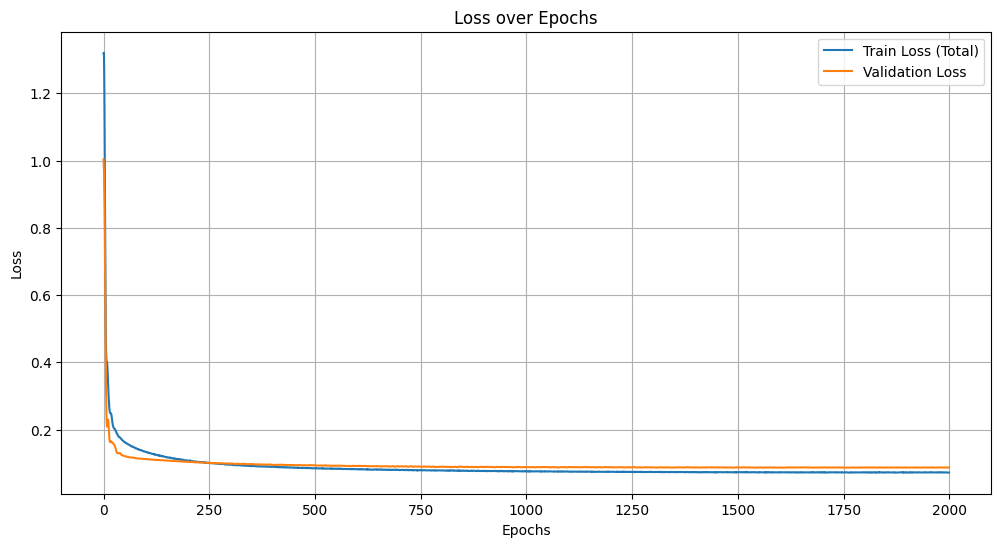

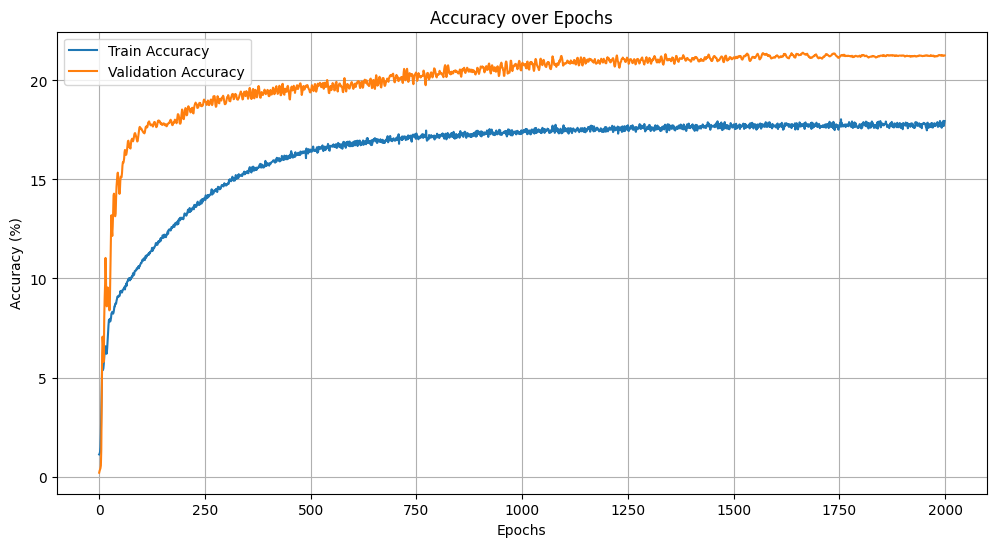

In [74]:
# Extraer métricas
train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accuracies = metrics["train_accuracies"]
val_accuracies = metrics["val_accuracies"]

# Graficar las pérdidas
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss (Total)")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

# Graficar el accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()


In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde,
    compute_accuracy_fn=compute_accuracy,
    device=device,
    epochs=2000,
    alpha=0
)

Epoch 1/2000, Train Loss: 1.238571, Train Data Loss: 1.238571, Train Physics Loss: 0.659582, Train Accuracy: 1.16%, Validation Loss: 1.021218, Validation Accuracy: 0.28%
Epoch 2/2000, Train Loss: 1.233799, Train Data Loss: 1.233799, Train Physics Loss: 0.655950, Train Accuracy: 1.19%, Validation Loss: 0.992359, Validation Accuracy: 0.29%
Epoch 3/2000, Train Loss: 1.116015, Train Data Loss: 1.116015, Train Physics Loss: 0.648597, Train Accuracy: 1.28%, Validation Loss: 0.921079, Validation Accuracy: 0.32%
Epoch 4/2000, Train Loss: 0.903691, Train Data Loss: 0.903691, Train Physics Loss: 0.635722, Train Accuracy: 1.56%, Validation Loss: 0.801188, Validation Accuracy: 0.39%
Epoch 5/2000, Train Loss: 0.653237, Train Data Loss: 0.653237, Train Physics Loss: 0.637430, Train Accuracy: 2.21%, Validation Loss: 0.639256, Validation Accuracy: 0.63%
Epoch 6/2000, Train Loss: 0.444683, Train Data Loss: 0.444683, Train Physics Loss: 0.656820, Train Accuracy: 3.54%, Validation Loss: 0.458091, Validat

In [67]:
model = PINNWithResNet(input_channels=5, num_classes=5)
inputs = torch.rand(1, 5, 100, 100)  # Batch size=1, canales=5, altura=100, ancho=100
outputs = model(inputs)
print(f"Input shape: {inputs.shape}, Output shape: {outputs.shape}")

Input shape: torch.Size([1, 5, 100, 100]), Output shape: torch.Size([1, 5, 100, 100])


In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithResNet(input_channels=5, num_classes=5).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde,
    compute_accuracy_fn=compute_accuracy,
    device=device,
    epochs=200,
    alpha=0
)

Epoch 1/200, Train Loss: 1.588750, Train Data Loss: 1.588750, Train Physics Loss: 68.118698, Train Accuracy: 1.37%, Validation Loss: 1.014320, Validation Accuracy: 0.29%
Epoch 2/200, Train Loss: 1.588749, Train Data Loss: 1.588749, Train Physics Loss: 68.166756, Train Accuracy: 1.37%, Validation Loss: 1.021354, Validation Accuracy: 0.38%
Epoch 3/200, Train Loss: 1.092313, Train Data Loss: 1.092313, Train Physics Loss: 49.613663, Train Accuracy: 1.96%, Validation Loss: 1.008391, Validation Accuracy: 0.39%
Epoch 4/200, Train Loss: 0.756118, Train Data Loss: 0.756118, Train Physics Loss: 49.158890, Train Accuracy: 2.89%, Validation Loss: 0.977814, Validation Accuracy: 0.52%
Epoch 5/200, Train Loss: 0.620960, Train Data Loss: 0.620960, Train Physics Loss: 39.223259, Train Accuracy: 4.23%, Validation Loss: 0.931313, Validation Accuracy: 0.67%
Epoch 6/200, Train Loss: 0.438322, Train Data Loss: 0.438322, Train Physics Loss: 18.200905, Train Accuracy: 5.32%, Validation Loss: 0.869225, Validat

In [77]:
def loss_pde_2(model, inputs, alpha=1.0, beta_momentum=1.0, beta_continuity=1.0, beta_energy=1.0, beta_moisture=1.0):
    inputs.requires_grad_(True)
    pred = model(inputs)

    u_pred, v_pred, p_pred, T_pred, q_pred = pred[:, 0, :, :], pred[:, 1, :, :], pred[:, 2, :, :], pred[:, 3, :, :], pred[:, 4, :, :]

    # Calcular gradientes
    u_x, u_y, u_t = compute_gradients(u_pred, inputs)
    v_x, v_y, v_t = compute_gradients(v_pred, inputs)
    T_x, T_y, T_t = compute_gradients(T_pred, inputs)
    q_x, q_y, q_t = compute_gradients(q_pred, inputs)
    p_x, p_y, _ = compute_gradients(p_pred, inputs)

    # Ecuaciones físicas
    momentum_u = u_t + u_pred * u_x + v_pred * u_y + p_x
    momentum_v = v_t + u_pred * v_x + v_pred * v_y + p_y
    continuity = u_x + v_y
    energy = T_t + u_pred * T_x + v_pred * T_y
    moisture = q_t + u_pred * q_x + v_pred * q_y

    # Pérdida física con pesos
    loss_physics = (
        beta_momentum * (torch.mean(momentum_u ** 2) + torch.mean(momentum_v ** 2)) +
        beta_continuity * torch.mean(continuity ** 2) +
        beta_energy * torch.mean(energy ** 2) +
        beta_moisture * torch.mean(moisture ** 2)
    )

    return alpha * loss_physics


In [79]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde_2,
    compute_accuracy_fn=compute_accuracy,
    device=device,
    epochs=2000,
    alpha=0.1
)

Epoch 1/2000, Train Loss: 1.276523, Train Data Loss: 1.208376, Train Physics Loss: 0.681469, Train Accuracy: 1.09%, Validation Loss: 0.998942, Validation Accuracy: 0.22%
Epoch 2/2000, Train Loss: 1.278467, Train Data Loss: 1.209918, Train Physics Loss: 0.685487, Train Accuracy: 1.12%, Validation Loss: 0.970281, Validation Accuracy: 0.21%
Epoch 3/2000, Train Loss: 1.156038, Train Data Loss: 1.088413, Train Physics Loss: 0.676254, Train Accuracy: 1.20%, Validation Loss: 0.900923, Validation Accuracy: 0.22%
Epoch 4/2000, Train Loss: 0.951846, Train Data Loss: 0.884270, Train Physics Loss: 0.675766, Train Accuracy: 1.46%, Validation Loss: 0.786201, Validation Accuracy: 0.24%
Epoch 5/2000, Train Loss: 0.713300, Train Data Loss: 0.645929, Train Physics Loss: 0.673706, Train Accuracy: 2.07%, Validation Loss: 0.632229, Validation Accuracy: 0.40%
Epoch 6/2000, Train Loss: 0.505845, Train Data Loss: 0.437578, Train Physics Loss: 0.682667, Train Accuracy: 3.47%, Validation Loss: 0.462418, Validat

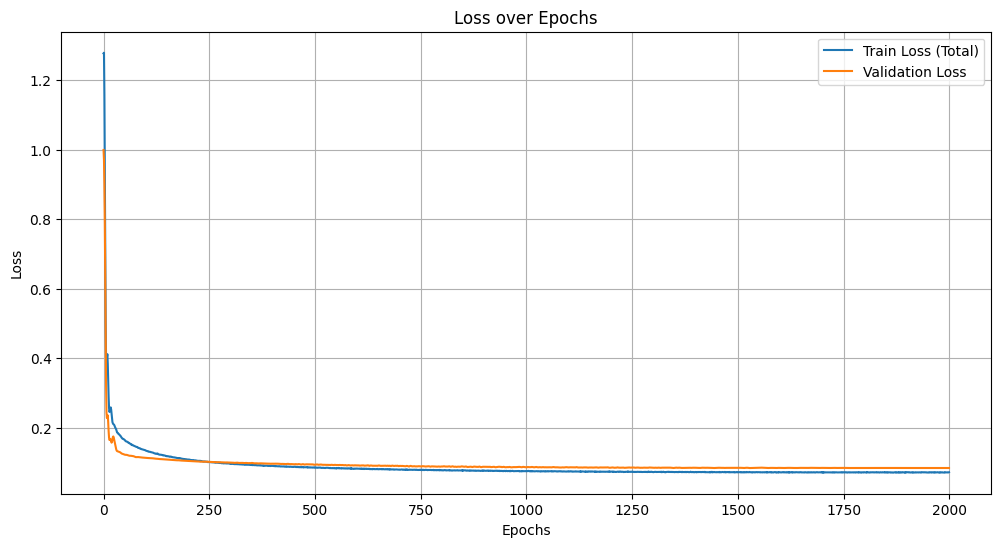

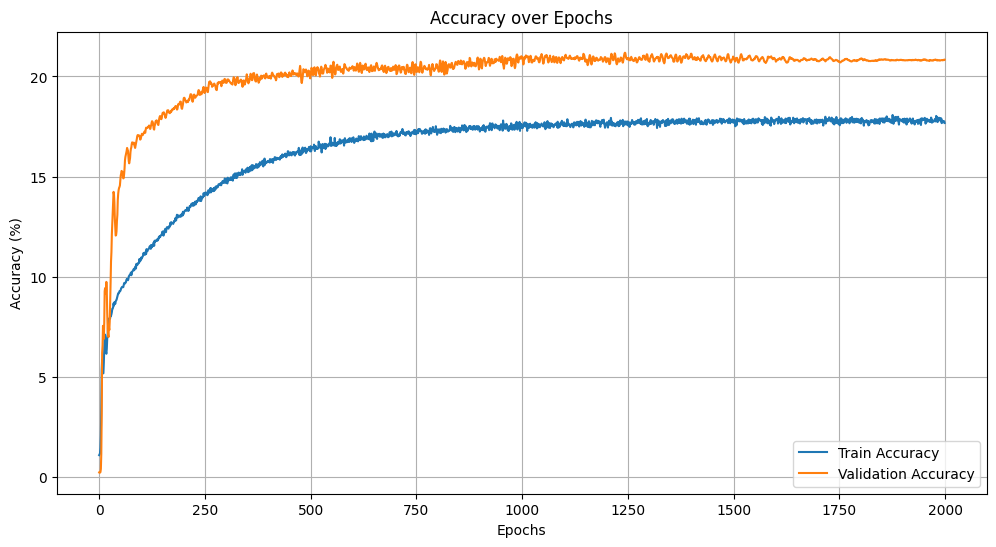

In [80]:
# Extraer métricas
train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accuracies = metrics["train_accuracies"]
val_accuracies = metrics["val_accuracies"]

# Graficar las pérdidas
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss (Total)")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

# Graficar el accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Verificar los límites del subset
lat_min = chile_ds['latitude'].min().values
lat_max = chile_ds['latitude'].max().values
lon_min = chile_ds['longitude'].min().values
lon_max = chile_ds['longitude'].max().values

print(f"Rango de latitud seleccionado: {lat_min} a {lat_max}")
print(f"Rango de longitud seleccionado: {lon_min} a {lon_max}")

Rango de latitud seleccionado: -56.0 a -17.0
Rango de longitud seleccionado: 280.0 a 310.0


In [ ]:
# Verificar los límites del subset
lat_min = chile_ds['latitude'].min().values
lat_max = chile_ds['latitude'].max().values
lon_min = chile_ds['longitude'].min().values
lon_max = chile_ds['longitude'].max().values

print(f"Rango de latitud seleccionado: {lat_min} a {lat_max}")
print(f"Rango de longitud seleccionado: {lon_min} a {lon_max}")

Rango de latitud seleccionado: -56.0 a -17.0
Rango de longitud seleccionado: 280.0 a 310.0


In [ ]:
# Verificar los límites del subset
lat_min = chile_ds['latitude'].min().values
lat_max = chile_ds['latitude'].max().values
lon_min = chile_ds['longitude'].min().values
lon_max = chile_ds['longitude'].max().values

print(f"Rango de latitud seleccionado: {lat_min} a {lat_max}")
print(f"Rango de longitud seleccionado: {lon_min} a {lon_max}")

Rango de latitud seleccionado: -56.0 a -17.0
Rango de longitud seleccionado: 280.0 a 310.0


In [ ]:
# Verificar los límites del subset
lat_min = chile_ds['latitude'].min().values
lat_max = chile_ds['latitude'].max().values
lon_min = chile_ds['longitude'].min().values
lon_max = chile_ds['longitude'].max().values

print(f"Rango de latitud seleccionado: {lat_min} a {lat_max}")
print(f"Rango de longitud seleccionado: {lon_min} a {lon_max}")

Rango de latitud seleccionado: -56.0 a -17.0
Rango de longitud seleccionado: 280.0 a 310.0


In [ ]:
# Verificar los límites del subset
lat_min = chile_ds['latitude'].min().values
lat_max = chile_ds['latitude'].max().values
lon_min = chile_ds['longitude'].min().values
lon_max = chile_ds['longitude'].max().values

print(f"Rango de latitud seleccionado: {lat_min} a {lat_max}")
print(f"Rango de longitud seleccionado: {lon_min} a {lon_max}")

Rango de latitud seleccionado: -56.0 a -17.0
Rango de longitud seleccionado: 280.0 a 310.0


In [83]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithCNN().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde_2,
    compute_accuracy_fn=compute_accuracy,
    device=device,
    epochs=2000,
    alpha=0.1
)

Epoch 1/2000, Train Loss: 0.909132, Train Data Loss: 0.428084, Train Physics Loss: 4.810479, Train Accuracy: 5.53%, Validation Loss: 0.175587, Validation Accuracy: 12.30%
Epoch 2/2000, Train Loss: 0.910307, Train Data Loss: 0.427236, Train Physics Loss: 4.830708, Train Accuracy: 5.56%, Validation Loss: 0.173866, Validation Accuracy: 12.19%
Epoch 3/2000, Train Loss: 0.837805, Train Data Loss: 0.386247, Train Physics Loss: 4.515576, Train Accuracy: 5.80%, Validation Loss: 0.167488, Validation Accuracy: 13.36%
Epoch 4/2000, Train Loss: 0.729472, Train Data Loss: 0.323919, Train Physics Loss: 4.055532, Train Accuracy: 6.55%, Validation Loss: 0.160124, Validation Accuracy: 15.93%
Epoch 5/2000, Train Loss: 0.627661, Train Data Loss: 0.274456, Train Physics Loss: 3.532043, Train Accuracy: 7.11%, Validation Loss: 0.159707, Validation Accuracy: 17.24%
Epoch 6/2000, Train Loss: 0.579316, Train Data Loss: 0.270294, Train Physics Loss: 3.090215, Train Accuracy: 6.87%, Validation Loss: 0.172825, Va

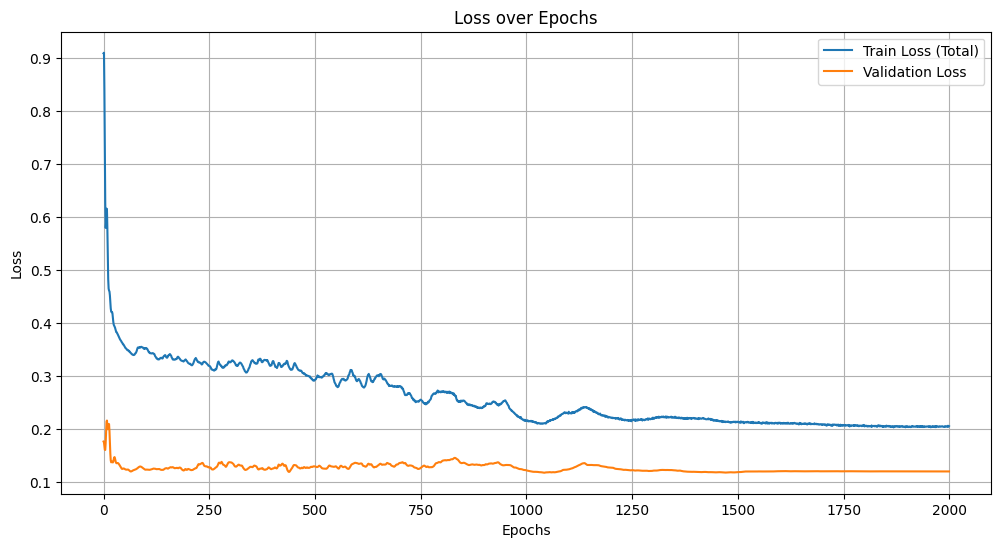

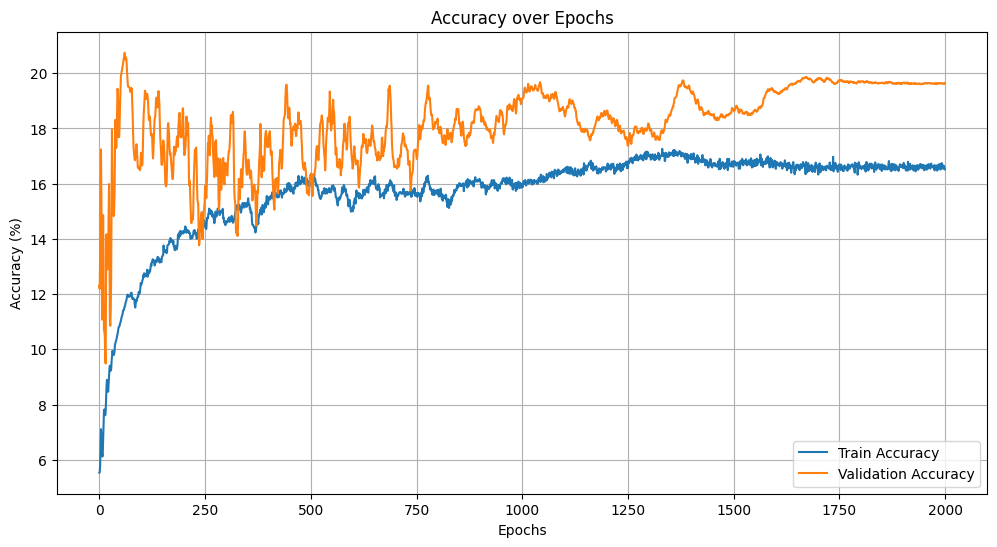

In [88]:
# Extraer métricas
train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accuracies = metrics["train_accuracies"]
val_accuracies = metrics["val_accuracies"]

# Graficar las pérdidas
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss (Total)")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

# Graficar el accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()


In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithCNNAndAttention().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde_2,
    compute_accuracy_fn=compute_accuracy,
    device=device,
    epochs=2000,
    alpha=0.1
)


Epoch 1/2000, Train Loss: 1.025183, Train Data Loss: 1.013009, Train Physics Loss: 0.121740, Train Accuracy: 0.62%, Validation Loss: 0.993377, Validation Accuracy: 0.11%
Epoch 2/2000, Train Loss: 1.024004, Train Data Loss: 1.011842, Train Physics Loss: 0.121623, Train Accuracy: 0.62%, Validation Loss: 0.982334, Validation Accuracy: 0.12%
Epoch 3/2000, Train Loss: 0.965550, Train Data Loss: 0.953422, Train Physics Loss: 0.121280, Train Accuracy: 0.66%, Validation Loss: 0.957338, Validation Accuracy: 0.12%
Epoch 4/2000, Train Loss: 0.854424, Train Data Loss: 0.842333, Train Physics Loss: 0.120909, Train Accuracy: 0.73%, Validation Loss: 0.914646, Validation Accuracy: 0.13%
Epoch 5/2000, Train Loss: 0.710668, Train Data Loss: 0.698633, Train Physics Loss: 0.120349, Train Accuracy: 0.92%, Validation Loss: 0.850712, Validation Accuracy: 0.16%
Epoch 6/2000, Train Loss: 0.561010, Train Data Loss: 0.548950, Train Physics Loss: 0.120603, Train Accuracy: 1.33%, Validation Loss: 0.763220, Validat

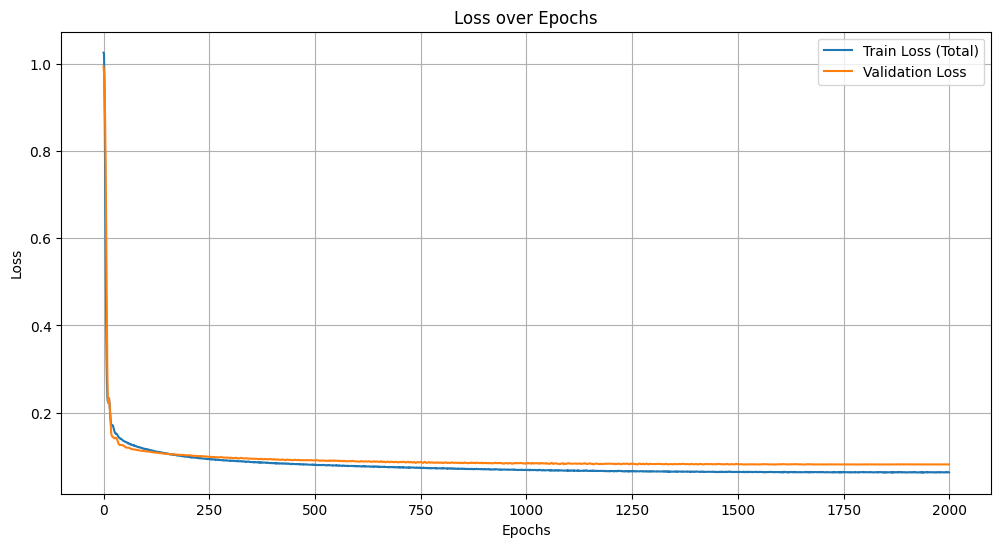

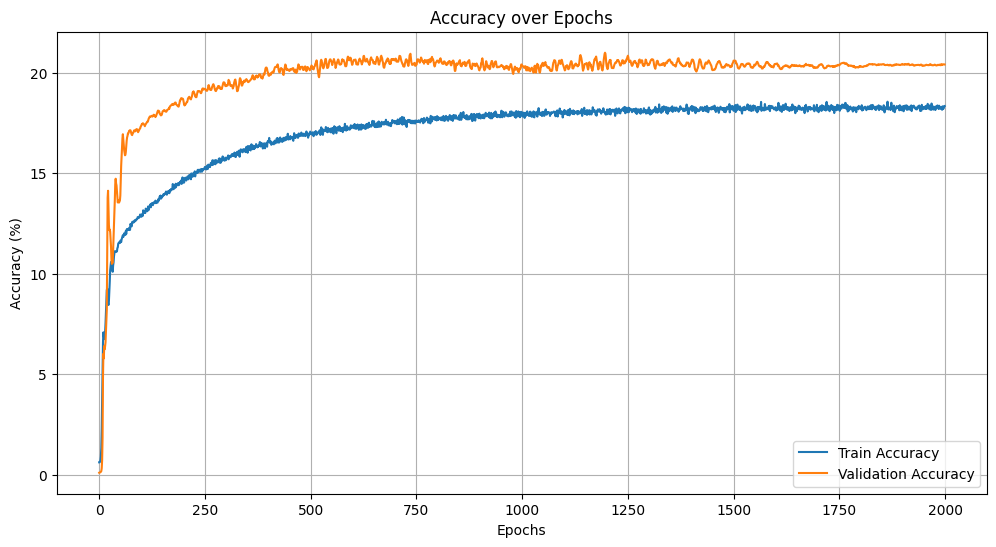

In [90]:
# Extraer métricas
train_losses = metrics["train_losses"]
val_losses = metrics["val_losses"]
train_accuracies = metrics["train_accuracies"]
val_accuracies = metrics["val_accuracies"]

# Graficar las pérdidas
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label="Train Loss (Total)")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

# Graficar el accuracy
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()


In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINNWithCNNAndAttention().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
metrics = train_model_with_physics(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_pde_fn=loss_pde_2,
    compute_accuracy_fn=compute_accuracy,
    device=device,
    epochs=2000,
    alpha=0
)

Epoch 1/2000, Train Loss: 1.023783, Train Data Loss: 1.023783, Train Physics Loss: 0.135545, Train Accuracy: 0.69%, Validation Loss: 0.992916, Validation Accuracy: 0.06%
Epoch 2/2000, Train Loss: 1.025545, Train Data Loss: 1.025545, Train Physics Loss: 0.135110, Train Accuracy: 0.69%, Validation Loss: 0.983282, Validation Accuracy: 0.08%
Epoch 3/2000, Train Loss: 0.965940, Train Data Loss: 0.965940, Train Physics Loss: 0.134464, Train Accuracy: 0.74%, Validation Loss: 0.960787, Validation Accuracy: 0.09%
Epoch 4/2000, Train Loss: 0.856306, Train Data Loss: 0.856306, Train Physics Loss: 0.133237, Train Accuracy: 0.85%, Validation Loss: 0.921490, Validation Accuracy: 0.08%
Epoch 5/2000, Train Loss: 0.714508, Train Data Loss: 0.714508, Train Physics Loss: 0.131128, Train Accuracy: 1.06%, Validation Loss: 0.861826, Validation Accuracy: 0.14%
Epoch 6/2000, Train Loss: 0.562927, Train Data Loss: 0.562927, Train Physics Loss: 0.127365, Train Accuracy: 1.48%, Validation Loss: 0.778345, Validat